# Neurónová sieť
Rozpoznávanie a generovanie textu

Kniha Rivers of Babylon od Petra Pišťanka

prvý odstavec z knihy

*Ráno sa kotolník zobúdza s takou nenávisťou v duši, že mu ani jesť nechutí. Vylihuje na drevenej lavici, škrabe si svrbiacu kožu, napnutú na vysadených rebrách, a tupo sa obzerá. Neskúša premýšľať nad zdrojom tejto nenávisti. Kotolňa je temná, so zájdenými a obitými stenami. Vychladnuté kotly sa rysujú v tme. Preháňa sa v nich vietor.*


ráno sa kotolník zobúdza s -  **takou**

sa kotolník zobúdza s takou - **nenávisťou**

kotolník zobúdza s takou nenávisťou - **v**

zobúdza s takou nenávisťou v - **duši**

s takou nenávisťou v duši - **že**

takou nenávisťou v duši že - **mu**

nenávisťou v duši že mu - **ani**

v duši že mu ani - **jesť**

duši že mu ani jesť– **nechutí**



In [1]:
#načítanie knihy 
#načítanie knihy
kniha1 = open('./Rivers of Babylon.txt', 'r', encoding="utf8")
kniha1 = kniha1.read()
#kniha1

Zoznam slov z knihy

In [2]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

slova = word_tokenize(kniha1.lower())
slova [:30]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\llack\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['ráno',
 'sa',
 'kotolník',
 'zobúdza',
 's',
 'takou',
 'nenávisťou',
 'v',
 'duši',
 ',',
 'že',
 'mu',
 'ani',
 'jesť',
 'nechutí',
 '.',
 'vylihuje',
 'na',
 'drevenej',
 'lavici',
 ',',
 'škrabe',
 'si',
 'svrbiacu',
 'kožu',
 ',',
 'napnutú',
 'na',
 'vysadených',
 'rebrách']

Vytvorenie vyčisteného zoznamu slov

In [3]:
import string
zoznam_slov = []
neabecedne_znaky = string.punctuation
neabecedne_znaky

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [4]:
for slovo in slova:
        for char in slovo:
            if char in neabecedne_znaky:
                slovo = slovo.replace(char, "")
        if slovo not in neabecedne_znaky:
            zoznam_slov.append(slovo)
print("Počet slov:", len(zoznam_slov), "unikátnych", len(set(zoznam_slov)))
zoznam_slov [:30]

Počet slov: 90374 unikátnych 19679


['ráno',
 'sa',
 'kotolník',
 'zobúdza',
 's',
 'takou',
 'nenávisťou',
 'v',
 'duši',
 'že',
 'mu',
 'ani',
 'jesť',
 'nechutí',
 'vylihuje',
 'na',
 'drevenej',
 'lavici',
 'škrabe',
 'si',
 'svrbiacu',
 'kožu',
 'napnutú',
 'na',
 'vysadených',
 'rebrách',
 'a',
 'tupo',
 'sa',
 'obzerá']

slovník a transformácia slov na číselné hodnoty

Pomocou funkcie enumerate() slová z našej dátovej množiny očíslujeme

In [7]:
slovnik= set(zoznam_slov) #unikátne slová
print("Slovná zásoba na trénovanie má", len(zoznam_slov),"slov, unikátnych slov je", len(slovnik))
indexy_slov = {slovo: i for i, slovo in enumerate(slovnik)}
zoznam_indexov_slov = [indexy_slov[slovo] for slovo in zoznam_slov]
zoznam_indexov_slov[:10]
#zoznam_slov[:10]
#indexy_slov

Slovná zásoba na trénovanie má 90374 slov, unikátnych slov je 19679


[4021, 16558, 318, 11758, 19393, 19451, 746, 19370, 10975, 12644]

trénovacia množina, pätice za sebou idúcich slov, zakaždým o jeden index posunuté

In [8]:
davka=5
pocet_slov = len(zoznam_slov) #pocet slov knihy
trenovacia_mnozina = [([zoznam_indexov_slov[i], zoznam_indexov_slov[i+1], zoznam_indexov_slov[i+2], zoznam_indexov_slov[i+3],
                        zoznam_indexov_slov[i+4]], zoznam_indexov_slov[i+5]) for i in range(pocet_slov-davka) ]
trenovacia_mnozina[:10]

[([4021, 16558, 318, 11758, 19393], 19451),
 ([16558, 318, 11758, 19393, 19451], 746),
 ([318, 11758, 19393, 19451, 746], 19370),
 ([11758, 19393, 19451, 746, 19370], 10975),
 ([19393, 19451, 746, 19370, 10975], 12644),
 ([19451, 746, 19370, 10975, 12644], 7350),
 ([746, 19370, 10975, 12644, 7350], 2398),
 ([19370, 10975, 12644, 7350, 2398], 17736),
 ([10975, 12644, 7350, 2398, 17736], 1996),
 ([12644, 7350, 2398, 17736, 1996], 17400)]

**Trieda dedfinujúca model neurónovej siete**

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

embedding_dim = 5  #veľkosť embedding vektorov
# === Trieda definujúca model neurónovej siete ===
# Embedding (vložená vrstva) je skrytá vrstva NS ktorá
# mapuje vstupné informácie z vysoko do nízko rozmerného priestoru

class Model_NS(nn.Module):
  def __init__(self, pocet_slov, embedding_dim, davka):
    super(Model_NS, self).__init__()
    self.embeddings = nn.Embedding(pocet_slov, embedding_dim)
    self.linear1 = nn.Linear(davka * embedding_dim,128)  # lineárne transformácie ako vrstvy NS
    self.linear2 = nn.Linear(128, 512)
    self.linear3 = nn.Linear(512, pocet_slov)

   # pri predpovedaní informácie prúdia „dopredu“
   # zo vstupu cez skryté vrstvy na výstup
   # výstupom sú logaritmy pravdepodobností
  def forward(self, inputs):  # pri predpovedaní
    embs = self.embeddings(inputs).view((1,-1))
    out = F.relu(self.linear1(embs)) #lineárna aktivačná funkcia
    out = F.relu(self.linear2(out))
    out = self.linear3(out)
    log_pravdepodobnosti = F.log_softmax(out, dim=1) #konvertuje číselné hodnoty na pravdepodobnosti
    return log_pravdepodobnosti

In [10]:
# výpis parametrov modelu
model = Model_NS(pocet_slov, embedding_dim, davka)
print(model.embeddings,"\n")
model

Embedding(90374, 5) 



Model_NS(
  (embeddings): Embedding(90374, 5)
  (linear1): Linear(in_features=25, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=90374, bias=True)
)

**Trénovanie modelu**

In [ ]:
# === trénovanie modelu ===
from torch.cuda import is_available

# Pokiaľ možno na GPU
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

priebezne_chyby = []  # chyby po každých 1000 krokoch trénovania


def trenovanie(model, trenovacie_data, n_iteracie, word_to_index):
  model.to(device)
  for i in range(n_iteracie):
    model.train()
    krok = 0
    perioda_vypisu = 1000
    akumulovana_chyba = 0  # na výpočet priemernej chyby po každých 1000 krokoch

    for feature, target in trenovacie_data:
      feature_tensor = torch.tensor([feature], dtype=torch.long)
      feature_tensor = feature_tensor.to(device)
      target_tensor = torch.tensor([target], dtype=torch.long)
      target_tensor = target_tensor.to(device)
      model.zero_grad()  #vynulovanie gradientov
      log_probs = model(feature_tensor)
      loss = criterion(log_probs, target_tensor)
    
    #Spätný prechod pri aktualizácii parametrov
      loss.backward()    #Spätný prechod pri aktualizácii parametrov
      optimizer.step()
      akumulovana_chyba += loss.item()
      krok+=1

      if krok % perioda_vypisu == 0:  #každých 1000 krokov
        model.eval()
        priemerna_chyba = akumulovana_chyba/perioda_vypisu
        priebezne_chyby.append(priemerna_chyba) #pridám do zoznamu
        print(i+1,"z",n_iteracie, "iterácií", krok,"krok z",pocet_slov,
               "Chyba: {:.3f}".format(priemerna_chyba))
        akumulovana_chyba=0
    model.train()
  return model


**Spätná propagácia – (backward propagation)**
rieši úpravu váh neurónových spojení tak, aby neurónová sieť poskytovala výstup, ktorý je bližší k požadovanému výsledku, čiže minimalizujeme stratovú funkciu. 

Tento proces prebieha opačne od výstupov k vstupom. Ako prvý sa vypočíta gradient váh poslednej výstupnej vrstvy a ako posledný sa vypočíta gradient váh prvej vrstvy. 

Výsledky výpočtu gradientu z príslušnej  vrstvy sa použijú pri výpočte gradientu pre predchádzajúcu vrstvu.

**Spustenie trénovania pre daný počet iterácií**

In [ ]:
model = Model_NS(pocet_slov, embedding_dim, davka)
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01)

n_iteracie = 10

start_time = time.time()

model = trenovanie(model, trenovacia_mnozina, n_iteracie, indexy_slov)
print("Trénovanie modelu trvalo {} minút".format(round((start_time - time.time())/60),2))

# Doplnenie modelu
model.average_loss = priebezne_chyby
model.optimizer_state = optimizer.state_dict()
model.word_to_index = indexy_slov,
model.index_to_word = {i: word for i, word in enumerate(slovnik)}

In [ ]:
model.device = device

**Graf priebežných chýb počas trénovania**

<Axes: >

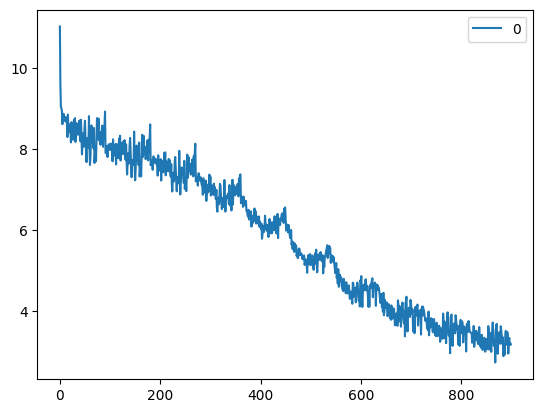

In [ ]:
import pandas as pd

loss_plot = pd.DataFrame(priebezne_chyby)
loss_plot.plot()

**Funkcia na predpovedanie slov poviedky**

In [ ]:
import pandas as pd
import random


def predpoved(model, zaciatok_poviedky ,dlzka_poviedky ,top_slova):
    # top_slova - slovo sa vyberie náhodne z top_k počtu

    # Prvých 5 slov do poviedky
    vstupy = (zaciatok_poviedky.lower()).split(" ") # Prvých 5 slov
    for i in vstupy:
        poviedka.append(i)
    for i in range(dlzka_poviedky):
        # slová na čísla (indexy)
        vstupy_ix = torch.tensor([indexy_slov[word] for word in vstupy], dtype=torch.long)
        vstupy_ix = vstupy_ix.to(device)
        with torch.no_grad(): # nevoláme Tensor.backward() nemusíme počítať gradienty
            output = model.double().forward(vstupy_ix)
        ps = torch.exp(output)
        top_kombinacia_indexy = ps.topk(top_slova, sorted=True)
        #top_n najpravdepodobnejších slov
        topk_ps = top_kombinacia_indexy[0][0]
        top_ntica = top_kombinacia_indexy[1][0]
        top_ntica = [model.index_to_word[int(i)] for i in top_ntica]
        # náhodný výber slova z top_n
        next_word = random.choice(top_ntica)
        vstupy = vstupy[1:]  # pridanie slova do vstupov a posunutie
        vstupy.append(next_word)
        poviedka.append(next_word)  # pridanie slova do poviedky
    return poviedka

**Generovanie poviedky**

In [ ]:
zaciatok_poviedky = input('Zadaj prvých {} slov poviedky:\n'.format(davka))

top_slova = 3 # Slovo sa vyberie náhodne z top_k počtu
dlzka_poviedky = 20
poviedka = []

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

# osetrenie vstupu, treba zadať 5 slov, ktoré model pozná
try:
    predikcia = predpoved(model, zaciatok_poviedky, dlzka_poviedky, top_slova)
except KeyError as error:
    print('niektorému zo slov zatiaľ nerozumiem\n zadaj slová z kníh na ktorých som sa učil nie ', error)
    if poviedka[0] != "":
        poviedka = poviedka[len(zaciatok_poviedky):]
    zaciatok_poviedky = input('zadaj slová ktorým rozumiem\n')
    predikcia = predpoved(model, zaciatok_poviedky, dlzka_poviedky, top_slova)
except KeyError and RuntimeError:
    if poviedka[0] != "":
        poviedka = poviedka[len(zaciatok_poviedky):]
    zaciatok_poviedky = input('Zadal si {} slov namiesto {}!\n\nZadaj presný počet slov\n'.format(len(zaciatok_poviedky.split(" ")), 5))
    predikcia = predpoved(model, zaciatok_poviedky, dlzka_poviedky, top_slova)

print('\n=== Poviedka ===')
print(" ".join(poviedka))

Zadaj prvých 5 slov poviedky:
obloha čoraz častejšie dostáva farbu

=== Poviedka ===
obloha čoraz častejšie dostáva farbu pri kotla tvárami laza aj dolu vezme o ráz chodníku až za keď po chvíli ale patrí na právnika zatiaľ


In [ ]:
Vygenerovaný text po dvoch iteráciách trénovania po zadaní piatich slov:“obloha čoraz častejšie dostáva farbu“

obloha čoraz častejšie dostáva farbu na nevinných no trolejbusom do vily že ho do nechápavo 
až vám keď nesie oblokom fitness že kvapku rácz s prsty ktorý stisnúť alebo jemu veď až 
na všetko fredyho a o ústam vzrušenia hneď rácz si sa necítia sebou pred sebou 
sa však a už dávno opäť stučnel stáť

Po ďalších spusteniach
obloha čoraz častejšie dostáva farbu pred všetkých života o hotelovej veľa rácz 
mohol rácz vzdiali ako sám niekedy strach s sa platnosťou že za slobodu a čo si 
chceli rácz sem no kedysi že nemá to že si sa im skončí lesknú a pozerá si dnes stôl 
každý mu nikdy pred svoju sa stane naučil

obloha čoraz častejšie dostáva farbu sa nikomu ovisnutými sme ticho nový primátor 
je tmy ale inde tí sa pred seba zatvorí si o dva roky pred viacerých z dvore strany na sebou 
budov pred hotelom roboty a tiež svoj na fiškála každý sa s fľašou kotolníkom on rácz 
on rácz je predsa dal svoju mesta

obloha čoraz častejšie dostáva farbu sa a pod kým kotolňu a čo ešte stále si manželky právnik 
od vždy dva hotely sa dolu chcieť sa nad mestom adaptácia už sa že spýta cenu 
si potiahne rácz pokojne na nikdy jednom ju hádam ideme ako po službe no práve sa 
ako navrhne si sa z rúk
